In [3]:
import os
import time

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as tvutils

# import cv2
# import PIL
# import matplotlib.pyplot as plt

from my_utils.vis import *

from data.dataset import make_dataset, MyDataset
from data.loader import load_frames
from data.preprocess import sub_mean, reduce, check_data

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [4]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:{1}" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:1 now!


In [40]:
png_root='/mnt/cfs/wangyh/blender/blank_wall/output_png_test'
dataset_dir='/mnt/cfs/wangyh/blender/blank_wall/datasets/unseen_256_noise_0.01'
check_dict = {
    'actions': ['Clapping', 'Flair', 'Jump', 'Jumping Jacks', 'Rumba Dancing'],
    'characters': ['Jody'],
    'light_types': ['AREA', 'POINT'],
    'light_energy_modes': ['1'],
    'light_position_modes': ['1', '2'],
    'scenes': ['un_seen']
}
stat_file = 'stat-7'

In [41]:
action_samples = check_data(check_dict, png_root, dataset_dir, stat_file)

100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.09it/s]

Clapping	 4
Flair	 4
Jump	 4
Jumping Jacks	 4
Rumba Dancing	 4


In [48]:
png_abs_dir = '/mnt/cfs/wangyh/blender/blank_wall/output_png_test/Clapping/Clapping_Jody_ltAREA_le1_lp1_un_seen'
frames = load_frames(png_abs_dir, device=device, frame_range=(0, 5), output_size=(256, 256))

In [49]:
frames.shape

torch.Size([5, 256, 256, 4])

In [5]:
frames[0]

tensor([[[ 65.,  58.,  56., 255.],
         [ 76.,  72.,  69., 255.],
         [ 69.,  64.,  61., 255.],
         ...,
         [ 38.,  30.,  26., 255.],
         [ 40.,  32.,  28., 255.],
         [ 33.,  27.,  26., 255.]],

        [[ 67.,  59.,  58., 255.],
         [ 80.,  75.,  74., 255.],
         [ 60.,  55.,  55., 255.],
         ...,
         [ 40.,  32.,  29., 255.],
         [ 40.,  32.,  29., 255.],
         [ 36.,  29.,  26., 255.]],

        [[ 70.,  66.,  64., 255.],
         [ 83.,  78.,  77., 255.],
         [ 77.,  72.,  72., 255.],
         ...,
         [ 44.,  34.,  32., 255.],
         [ 42.,  34.,  30., 255.],
         [ 36.,  29.,  27., 255.]],

        ...,

        [[ 73.,  66.,  64., 255.],
         [ 80.,  75.,  73., 255.],
         [ 80.,  76.,  74., 255.],
         ...,
         [ 71.,  65.,  64., 255.],
         [ 67.,  62.,  60., 255.],
         [ 63.,  58.,  57., 255.]],

        [[ 68.,  61.,  57., 255.],
         [ 74.,  68.,  67., 255.],
         [ 6

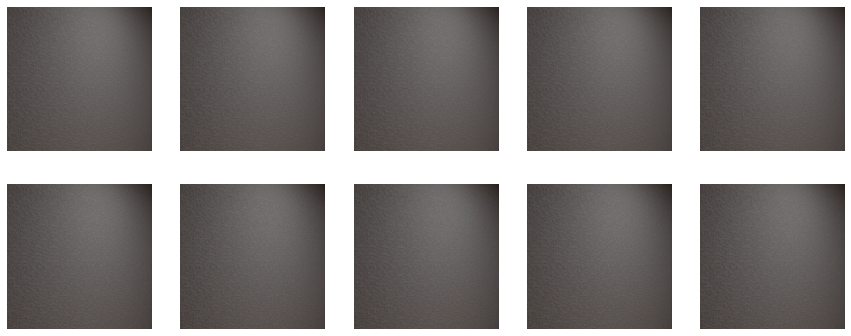

In [68]:
plt.figure(figsize=(15, 6))
for i, pic in enumerate(frames.cpu()[:,:,:,:3]):
    pic = pic.type(torch.int)
    plt.subplot(2,5,i+1)
    plt.imshow(pic)
    plt.axis('off')

    noisy_pic = pic + 255 * 0.01 * torch.randn_like(pic, dtype=torch.float)
    noisy_pic = noisy_pic.type(torch.int)
    plt.subplot(2,5,i+6)
    plt.imshow(noisy_pic)
    plt.axis('off')


In [42]:
make_dataset(stat_file=os.path.join(dataset_dir, stat_file),
             png_root=png_root,
             dataset_dir=dataset_dir,
             noise_factor=0.03,
             resize=(256, 256),
             device=device)

5 classes in total: {'Jumping Jacks', 'Rumba Dancing', 'Clapping', 'Jump', 'Flair'}


100%|███████████████████████████████████████████████| 20/20 [01:13<00:00,  3.66s/it]


In [71]:
T = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((128, 64)),
        # transforms.Normalize(mean, std)
    # transforms.ColorJitter(brightness=.1, hue=.1)
])

In [72]:
unseen_dataset = MyDataset(
    ROOT='/mnt/cfs/wangyh/blender/blank_wall/datasets/unseen_256_noise_0.01/',
    reduce_mode='W',
    transform=T
)
unseen_loader = DataLoader(unseen_dataset, batch_size=40, shuffle=False)
len(unseen_loader.dataset)
# print(unseen_loader.dataset[0][0].shape)

['Clapping', 'Flair', 'Jump', 'Jumping Jacks', 'Rumba Dancing']


40

In [47]:
unseen_dataset[0][0]

tensor([[[ 0.2225, -0.0135, -0.0426,  ..., -0.0209, -0.5126, -0.4418],
         [ 0.7548,  0.3150,  0.6869,  ...,  0.1850,  0.5677,  0.1027],
         [-0.4935, -0.0954,  0.1221,  ..., -0.5915,  0.0392,  0.0497],
         ...,
         [-0.0450, -0.1979, -0.4200,  ..., -0.1448,  0.4447, -0.0792],
         [-0.2782, -0.0391,  0.5841,  ...,  0.1520, -0.0765, -0.2365],
         [-0.4941, -0.1542,  0.5469,  ..., -0.2131, -0.2807,  0.0030]],

        [[-0.1023, -0.2187, -0.5875,  ...,  0.0335, -0.1391, -0.1360],
         [ 0.3544,  0.3085,  0.5375,  ..., -0.4503, -0.3023,  0.3435],
         [ 0.3759,  0.0220, -0.2332,  ..., -0.1849,  0.1373,  0.2099],
         ...,
         [ 0.1871, -0.0606, -0.0867,  ...,  0.0025, -0.7483,  0.6318],
         [ 0.6388,  1.0828, -0.2816,  ..., -0.2611,  0.2344, -0.0904],
         [-0.2241,  0.3012, -0.2517,  ...,  0.4135,  0.2188, -0.0230]],

        [[ 0.3545, -0.1305, -0.3479,  ..., -0.4033,  0.1455, -0.0361],
         [ 0.0613, -0.6168, -0.3303,  ..., -0

In [35]:
concrete_38_dataset = MyDataset(
    ROOT='/mnt/cfs/wangyh/blender/blank_wall/datasets/concrete_38-r0/',
    reduce_mode='W',
    transform=T
)
concrete_38_loader = DataLoader(concrete_38_dataset, batch_size=40, shuffle=False)
len(concrete_38_loader.dataset)

['Clapping', 'Flair', 'Jump', 'Jumping Jacks', 'Rumba Dancing']


40

In [22]:
concrete_48_dataset = MyDataset(
    ROOT='/mnt/cfs/wangyh/blender/blank_wall/datasets/cconcrete_48-r0/',
    reduce_mode='W',
    # transform=T
)
concrete_48_loader = DataLoader(concrete_48_dataset, batch_size=20, shuffle=False)
len(concrete_48_loader.dataset)

['Clapping', 'Flair', 'Jump', 'Jumping Jacks', 'Rumba Dancing']


20

In [11]:
camera_view_dataset = MyDataset(
    ROOT='/mnt/cfs/wangyh/blender/blank_wall/datasets/camera_view',
    reduce_mode='W',
    transform=T
)
camera_view_loader = DataLoader(camera_view_dataset, batch_size=20, shuffle=False)
len(camera_view_loader.dataset)

['Clapping', 'Flair', 'Jump', 'Jumping Jacks', 'Rumba Dancing']


20

In [ ]:
furniture_in_camera_dataset = MyDataset(
    ROOT='/mnt/cfs/wangyh/blender/blank_wall/datasets/furniture_in_camera',
    reduce_mode='W',
    transform=T
)
furniture_in_camera_loader = DataLoader(furniture_in_camera_dataset, batch_size=20, shuffle=False)
len(furniture_in_camera_loader.dataset)

In [38]:
furniture_in_camera2_dataset = MyDataset(ROOT=dataset_dir, reduce_mode='W')
furniture_in_camera2_loader = DataLoader(furniture_in_camera2_dataset, batch_size=20, shuffle=False)
len(furniture_in_camera2_loader.dataset)

['Clapping', 'Flair', 'Jump', 'Jumping Jacks', 'Rumba Dancing']


20

In [41]:
furniture_in_lightpath_dataset = MyDataset(
    ROOT='/mnt/cfs/wangyh/blender/blank_wall/datasets/furniture_in_lightpath',
    reduce_mode='W')
furniture_in_lightpath_loader = DataLoader(furniture_in_lightpath_dataset, batch_size=20, shuffle=False)
len(furniture_in_lightpath_loader.dataset)

['Clapping', 'Flair', 'Jump', 'Jumping Jacks', 'Rumba Dancing']


20

In [49]:
furniture_in_lightpath2_dataset = MyDataset(
    ROOT='/mnt/cfs/wangyh/blender/blank_wall/datasets/furniture_in_lightpath2',
    reduce_mode='W',
    transform=T
)
furniture_in_lightpath2_loader = DataLoader(furniture_in_lightpath2_dataset, batch_size=20, shuffle=False)
len(furniture_in_lightpath2_loader.dataset)

['Clapping', 'Flair', 'Jump', 'Jumping Jacks', 'Rumba Dancing']


20

In [52]:
furniture_in_lightpath2_dataset.data

[('/mnt/cfs/wangyh/blender/blank_wall/datasets/furniture_in_lightpath2/Clapping/Clapping_Jody_ltAREA_le1_lp2_furniture_in_lightpath2.mat',
  0),
 ('/mnt/cfs/wangyh/blender/blank_wall/datasets/furniture_in_lightpath2/Clapping/Clapping_Jody_ltPOINT_le1_lp1_furniture_in_lightpath2.mat',
  0),
 ('/mnt/cfs/wangyh/blender/blank_wall/datasets/furniture_in_lightpath2/Clapping/Clapping_Jody_ltPOINT_le1_lp2_furniture_in_lightpath2.mat',
  0),
 ('/mnt/cfs/wangyh/blender/blank_wall/datasets/furniture_in_lightpath2/Clapping/Clapping_Jody_ltAREA_le1_lp1_furniture_in_lightpath2.mat',
  0),
 ('/mnt/cfs/wangyh/blender/blank_wall/datasets/furniture_in_lightpath2/Flair/Flair_Jody_ltAREA_le1_lp2_furniture_in_lightpath2.mat',
  1),
 ('/mnt/cfs/wangyh/blender/blank_wall/datasets/furniture_in_lightpath2/Flair/Flair_Jody_ltPOINT_le1_lp2_furniture_in_lightpath2.mat',
  1),
 ('/mnt/cfs/wangyh/blender/blank_wall/datasets/furniture_in_lightpath2/Flair/Flair_Jody_ltAREA_le1_lp1_furniture_in_lightpath2.mat',
  1),


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

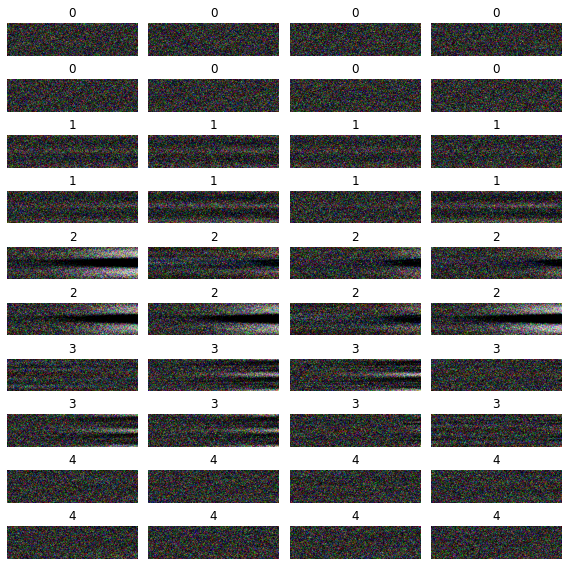

In [73]:
grid_vis(unseen_loader, row_num=10, multiply=1)

In [23]:
next(model.parameters()).device.index

1

In [21]:
from my_utils import models

model = models.NLOS_Conv().to(device)
model.load_state_dict(torch.load('/home/wangyh/01-Projects/01-NLOS/tb_logs/test_runs/2022_05_02_11_35_22/weights/100.0_2022_05_02_11_39_15.pt')['model_paras'])

<All keys matched successfully>

In [46]:
from my_utils.utils import check_accuracy

model.eval()
check_accuracy(model, unseen_loader)

Test accuracy is : 20.00%	Infer time: 0.478778600692749


In [69]:
inputs, labels = next(iter(unseen_loader))
print(inputs.shape)
print(labels)

torch.Size([40, 3, 128, 64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4])


In [70]:
model.eval()
scores = model(inputs.to(device))
preds = scores.argmax(dim=1)
print(preds)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:1')
